# Autoencoder for Image Compression
Used to generate compressed version of the images to feed into the cnn.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# dont use gpu [for M1/M2 Metal, cause it cant handle [presumably] Dropout Layers too well], comment out if you want to use GPU
# tf.config.set_visible_devices([], 'GPU') 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from keras import backend as K 
import gc
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from tensorflow.keras import regularizers
import json
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2

In [2]:
def plot_hist(history,name):
    acc = history.history['accuracy']
    val_acc = history.history.get('val_accuracy', None)
    plt.plot(acc, label='Training Accuracy')
    if val_acc is not None:
        plt.plot(val_acc, label='Validation Accuracy')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'for {name}')
    plt.legend()
    plt.savefig(f"./ae_files/{name}_acc.png")
    plt.show()


## Load Data and resample

In [3]:
data = pd.read_pickle('./data/images_df_numerical.pkl')
classes = data["Species"].unique()
number_of_classes = classes.size

# Alleiniges undersampling wird keinen Sinn machen, da wir extrem wenig Datenpunkte overall haben
def resample(resampler) -> tuple[np.array, np.array]:
    X, y = data['data'], data['Species']
    X, y = np.stack(X).astype(np.uint8), y.to_numpy().astype(np.uint8)
    X_resampled, y_resampled = resampler.fit_resample(X, y)

    print(f"{resampler}: ", pd.Series(y_resampled, dtype=pd.UInt8Dtype()).value_counts())

    X_resampled, y_resampled = shuffle(X_resampled, y_resampled, random_state=1)

    return X_resampled, y_resampled

# oversampling
smote = SMOTE()
adasyn = ADASYN()

X, y = resample(adasyn)

# Kombination aus over und undersampling
smoteenn = SMOTEENN()
smotettomek = SMOTETomek()

# get image informations

image_size = X[0].size
samples = X.size
with open("./data/meta.json","r") as file:  # get metadata for images from file generated from import nb
    image_meta = json.load(file) 
image_shape = (image_meta['h'],image_meta['w'],image_meta['c']) # hwc
print("Image has shape", image_shape)

X = X.reshape((-1,) + image_shape)

#convert from RGB to YCrCb (used for image compression)
X = np.array([cv2.cvtColor(img,cv2.COLOR_BGR2YCR_CB) for img in X])
# normalize
X = X / 255.

# split into color channels
X_y = X[...,0:1]
X_cr = X[...,1:2]
X_cb = X[...,2:3]

ADASYN():  2    2179
3    2116
0    2104
5    2097
4    2082
1    2018
Name: count, dtype: Int64
Image has shape (65, 100, 3)


### Build Auto-, En- and Decoder

In [4]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, min_delta=0.001, start_from_epoch=15, restore_best_weights=True)
epochs = 200
batch_size = 16

filter_sizes = [8,8,8,8,8,8]

# the model is meant to be used for (h,w,1), so for each luma component individual
# returns encoder, decoder and autoencoer
# silent: model summary
def create_models(silent=True):
    # for architecture, see: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8456308
    #encoder
    input_en = keras.Input(shape=(image_shape[0],image_shape[1],1), name="EN-IN")
    # downsampling unit 1
    x = keras.layers.Conv2D(filter_sizes[0], (3, 3), activation='PReLU', padding='same', strides=1, name="EN-DS1-1")(input_en)
    x = keras.layers.Conv2D(filter_sizes[1], (3, 3), activation='PReLU', padding='same', strides=2, name="EN-DS1-2")(x)
    # downsampling unit 2
    x = keras.layers.Conv2D(filter_sizes[2], (3, 3), activation='PReLU', padding='same', strides=1, name="EN-DS2-1")(x)
    x = keras.layers.Conv2D(filter_sizes[3], (3, 3), activation='PReLU', padding='same', strides=2, name="EN-DS2-2")(x)
    # downsampling unit 3
    x = keras.layers.Conv2D(filter_sizes[4], (3, 3), activation='PReLU', padding='same', strides=1, name="EN-DS3-1")(x)
    output_en = keras.layers.Conv2D(filter_sizes[5], (3, 3), activation='PReLU', padding='same', strides=2, name="EN-DS3-2")(x)

    encoder = keras.Model(input_en, output_en, name="Encoder")
    if not silent:
        encoder.summary()
    
    # decoder
    input_de = keras.Input(shape=(9,13,filter_sizes[5]), name="DE-IN")
    # upsampling unit 1
    x = keras.layers.Conv2DTranspose(filter_sizes[5], (3, 3), activation='PReLU', padding='same', strides=1, name="DE-DS1-1")(input_de)
    x = keras.layers.Conv2DTranspose(filter_sizes[5], (3, 3), activation='PReLU', padding='same', strides=2, name="DE-DS1-2")(x)
    # upsampling unit 2
    x = keras.layers.Conv2DTranspose(filter_sizes[5], (3, 3), activation='PReLU', padding='same', strides=1, name="DE-DS2-1")(x)
    x = keras.layers.Conv2DTranspose(filter_sizes[5], (3, 3), activation='PReLU', padding='same', strides=2, name="DE-DS2-2")(x)
    # upsampling unit 3
    x = keras.layers.Conv2DTranspose(filter_sizes[5], (3, 3), activation='PReLU', padding='same', strides=1, name="DE-DS3-1")(x)
    x = keras.layers.Conv2DTranspose(filter_sizes[5], (3, 3), activation='PReLU', padding='same', strides=2, name="DE-DS3-2")(x)
    # crop to match shape
    output_de = keras.layers.Cropping2D(cropping=((3,4),(2,2)))(x) # to get shape from (72,104,)
    
    decoder = keras.Model(input_de, output_de, name="Decoder")
    if not silent:
        decoder.summary()

    #autoencoder
    input_ae = keras.Input(shape=(image_shape[0],image_shape[1],1))
    x = encoder(input_ae)
    output_ae = decoder(x)
    
    autoencoder = keras.Model(input_ae, output_ae, name="Autoencoder")
    if not silent:
        autoencoder.summary()

    return encoder,decoder,autoencoder

models_y = create_models()
models_cr = create_models()
models_cb = create_models(False)


2023-12-27 03:57:28.762452: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-27 03:57:28.762479: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-27 03:57:28.762483: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-27 03:57:28.762516: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-27 03:57:28.762532: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EN-IN (InputLayer)          [(None, 65, 100, 1)]      0         
                                                                 
 EN-DS1-1 (Conv2D)           (None, 65, 100, 8)        52080     
                                                                 
 EN-DS1-2 (Conv2D)           (None, 33, 50, 8)         13784     
                                                                 
 EN-DS2-1 (Conv2D)           (None, 33, 50, 8)         13784     
                                                                 
 EN-DS2-2 (Conv2D)           (None, 17, 25, 8)         3984      
                                                                 
 EN-DS3-1 (Conv2D)           (None, 17, 25, 8)         3984      
                                                                 
 EN-DS3-2 (Conv2D)           (None, 9, 13, 8)          1520

## Train on Images

Epoch 1/3


2023-12-27 03:57:30.317646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


504/504 [==============================] - 15s 28ms/step - loss: 0.0232 - accuracy: 1.4077e-04 - val_loss: 0.0142 - val_accuracy: 1.7170e-05
Epoch 2/3
504/504 [==============================] - 13s 26ms/step - loss: 0.0140 - accuracy: 3.3310e-04 - val_loss: 0.0135 - val_accuracy: 3.6592e-04
Epoch 3/3
504/504 [==============================] - 13s 26ms/step - loss: 0.0134 - accuracy: 0.0010 - val_loss: 0.0131 - val_accuracy: 5.5624e-04


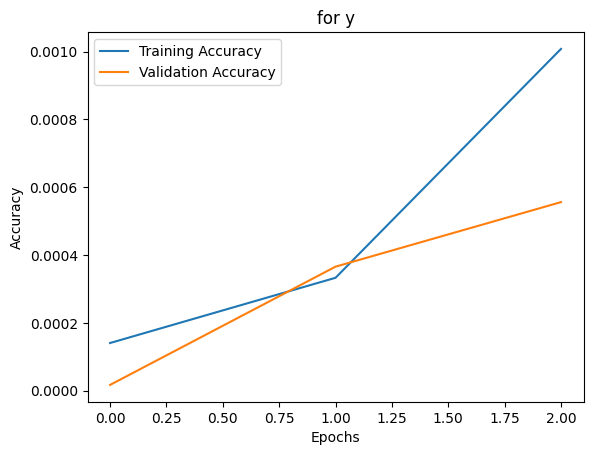

Epoch 1/3
504/504 [==============================] - 15s 28ms/step - loss: 0.0412 - accuracy: 0.0000e+00 - val_loss: 0.0127 - val_accuracy: 0.0000e+00
Epoch 2/3
504/504 [==============================] - 13s 26ms/step - loss: 0.0127 - accuracy: 0.0000e+00 - val_loss: 0.0124 - val_accuracy: 0.0000e+00
Epoch 3/3
504/504 [==============================] - 13s 26ms/step - loss: 0.0123 - accuracy: 0.0000e+00 - val_loss: 0.0121 - val_accuracy: 0.0000e+00


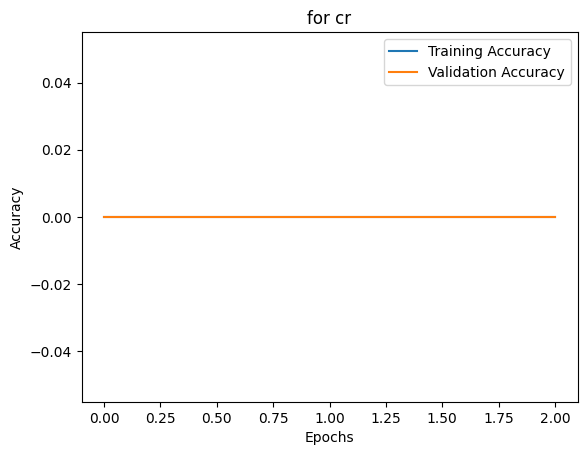

Epoch 1/3
504/504 [==============================] - 16s 29ms/step - loss: 0.0297 - accuracy: 2.6723e-07 - val_loss: 0.0093 - val_accuracy: 0.0000e+00
Epoch 2/3
504/504 [==============================] - 13s 26ms/step - loss: 0.0095 - accuracy: 1.9088e-08 - val_loss: 0.0091 - val_accuracy: 0.0000e+00
Epoch 3/3
504/504 [==============================] - 13s 26ms/step - loss: 0.0093 - accuracy: 4.0084e-07 - val_loss: 0.0089 - val_accuracy: 0.0000e+00


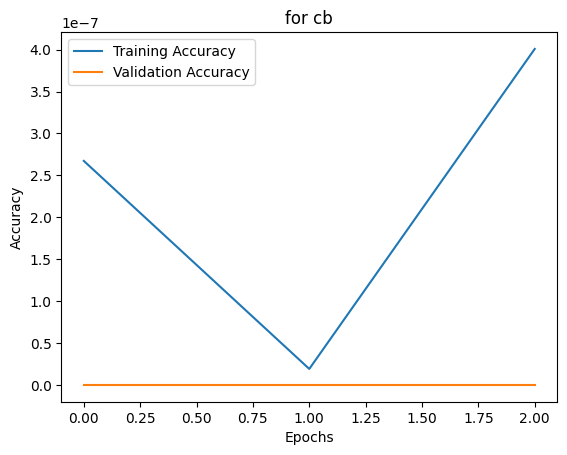

In [5]:

for en, de, ae, X, name in [(*models_y,X_y,"y"),(*models_cr,X_cr,"cr"),(*models_cb,X_cb,"cb")]:
    ae.compile(optimizer='adam', loss="mse", metrics=["accuracy"])

    X_train,X_test = train_test_split(X,test_size=0.2)
    history = ae.fit(
        X_train,
        X_train,
        epochs=200,
        batch_size=batch_size,
        #workers=8, # workers are number of cores
        callbacks=[early_stopping],
        validation_split=0.2,
        verbose=1)
    ae.save(f"./ae_files/ae_{name}.keras")
    en.save(f"./ae_files/en_{name}.keras")
    de.save(f"./ae_files/de_{name}.keras")
    plot_hist(history,name)
    

### Accuracy

### Generate compressed Dataset